# Emotion Detection  

In [1]:
%%capture
!pip install openpyxl==3.0.0
!pip install transformers

In [2]:
import openpyxl
print(f"openpyxl version: {openpyxl.__version__}")

import pandas as pd
import numpy as np
import re 
import time
import matplotlib.pyplot as plt
import seaborn as sns

openpyxl version: 3.0.0


In [3]:
# Mount drive to access files
%%capture
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive"

In [4]:
tweets_clean = pd.read_parquet('drive/My Drive/data/abudhabigp_tweets_clean.gzip')
tweets_clean

,id,date,interval,tweet,tweet_clean,hashtags,tweet_len,junk
0,0,2021-12-12 13:00:00,13:00,@MercedesAMGF1 My nerves are wrecking the anxi...,@MercedesAMGF1 My nerves are wrecking the anxi...,[],91,False
1,1,2021-12-12 13:00:00,13:00,Lets go! @LewisHamilton https://t.co/QiL9lWU6RQ,Lets go! @LewisHamilton,[],48,False
2,2,2021-12-12 13:00:00,13:00,Turn 1 anxiety #AbuDhabiGP,Turn 1 anxiety,[abudhabigp],27,False
3,3,2021-12-12 13:00:00,13:00,@piersmorgan @LewisHamilton Real brits pick wh...,@LewisHamilton Real brits pick who thay follow...,[],158,False
4,4,2021-12-12 13:00:00,13:00,@chris_tiffa @LewisHamilton Haha aye funny tha...,@LewisHamilton Haha aye funny that i dont trus...,[],73,False
...,...,...,...,...,...,...,...,...
252629,252629,2021-12-12 15:00:00,15:00,Welcome to AbbasMustan written and directed Ra...,Welcome to AbbasMustan written and directed Ra...,"[abudhabigp, maxverstappen, saifalikhan]",147,False
252630,252630,2021-12-12 15:00:00,15:00,"In years to come when I'm asked ""where were yo...","In years to come when I'm asked ""where were yo...",[],148,False
252631,252631,2021-12-12 15:00:00,15:00,Is it Friday the 13th Today? No #AbuDhabiGP ...,Is it Friday the 13th Today? No,"[abudhabigp, f1finale, hamilton, hamilton, for...",87,False
252632,252632,2021-12-12 15:00:00,15:00,Congratulations @LewisHamilton on your 8th tit...,Congratulations @LewisHamilton on your 8th tit...,[],184,False


### Sample the dataset proportionally
Due to the size of the dataset and runtime considerations, I segment the tweets using the 5 minute intervals created earlier and sample them for emotion detection.

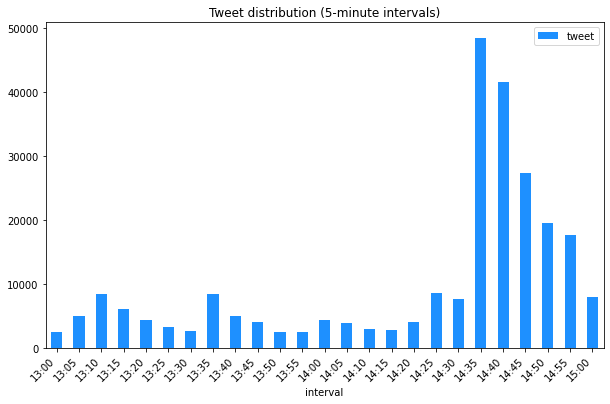

In [5]:
tweets_clean.groupby('interval').agg({'tweet': 'count'})\
.plot(kind = 'bar', color = 'dodgerblue', figsize = (10, 6))
plt.xticks(rotation = 45, ha = 'right')
plt.title('Tweet distribution (5-minute intervals)');

In [9]:
# Remove junk tweets and sample 10% of tweets from each interval
sampled_df = tweets_clean[tweets_clean['junk'] == False].copy()
print(f"{len(tweets_clean) - len(sampled_df)} tweets removed.")
sampled_df = sampled_df.groupby('interval')\
.apply(lambda x: x.sample(frac = 0.10, random_state = 3344)).reset_index(drop=True) 

# Rearrange the columns
sampled_df = sampled_df[['id', 'interval', 'date', 'tweet', 'tweet_clean', 
                         'hashtags', 'tweet_len', 'junk']]
sampled_df

print(f"{len(sampled_df)} tweets sampled.")
sampled_df.head()

438 tweets removed.
25218 tweets sampled.


,id,interval,date,tweet,tweet_clean,hashtags,tweet_len,junk
0,1432,13:00,2021-12-12 13:01:17,This is it. Don’t get scared now! #F1 https:/...,This is it. Don’t get scared now!,[f1],62,False
1,2277,13:00,2021-12-12 13:02:15,Godspeed @MercedesAMGF1 @LewisHamilton @Valtte...,Godspeed @MercedesAMGF1 @LewisHamilton @Valtte...,[],59,False
2,1633,13:00,2021-12-12 13:01:29,Coming into the final race of the season with ...,Coming into the final race of the season with ...,"[wtf1, abudabhigp, f1]",133,False
3,1870,13:00,2021-12-12 13:01:44,May the best man win. #Formula1,May the best man win.,[formula1],31,False
4,1856,13:00,2021-12-12 13:01:42,Here we go #AbuDhabiGP,Here we go,[abudhabigp],22,False


In [10]:
# Number of tweets sampled at each interval
sampled_df['interval'].value_counts().sort_index()

13:00     250
13:05     500
13:10     844
13:15     620
13:20     448
13:25     329
13:30     270
13:35     851
13:40     506
13:45     406
13:50     251
13:55     257
14:00     446
14:05     390
14:10     293
14:15     278
14:20     406
14:25     857
14:30     775
14:35    4841
14:40    4154
14:45    2733
14:50    1949
14:55    1768
15:00     796
Name: interval, dtype: int64

In [13]:
# Log the sampled ids
sampled_ids = sampled_df[['id', 'date', 'tweet_len']]
sampled_ids.to_parquet('drive/My Drive/data/sampled_ids.gzip', compression='gzip')

### Emotion detection
Using `EmoRoBERTa` transformer model

In [14]:
#!pip install transformers
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [15]:
# Pipeline abstraction
emotion = pipeline(task = 'sentiment-analysis', 
                   model = 'arpanghoshal/EmoRoBERTa', 
                   return_all_scores = False)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [16]:
# Demo
emotion("This was an epic championship battle check if there’re problematic characters! #AbuDhabiGP")

[{'label': 'approval', 'score': 0.29007282853126526}]

In [31]:
# Empty list to store dictionaries of emotions and scores
emotions_scores = []
assert len(emotions_scores) == 0, "List is not empty!"

# Reset index for range()
iter_df = sampled_df.reset_index(drop = True)

start_time = time.time()

for i in range(0, len(iter_df)):
  try:
    # Emotion detection
    emo = emotion(iter_df['tweet_clean'][i])[0] 

    # Append tweet id & output dict to list
    emo['id'] = iter_df['id'][i]
    emotions_scores.append(emo)

  except Exception as e: 
    print(f"Error at row {i} id {iter_df['id'][i]}: {iter_df['tweet_clean'][i]}")
    print(e)

  if i % 2500 == 0:
    print(f"{i} tweets analysed.")

print(f"Emotion detection for {len(emotions_scores)} tweets completed.")
print(f"Run time: {(time.time() - start_time)/60:.2f} minutes.")

0 tweets analysed.
2500 tweets analysed.
5000 tweets analysed.
7500 tweets analysed.
10000 tweets analysed.
12500 tweets analysed.
15000 tweets analysed.
17500 tweets analysed.
20000 tweets analysed.
22500 tweets analysed.
25000 tweets analysed.
Emotion detection for 25218 tweets completed.
Run time: 128.81 minutes.


In [52]:
all_emotions = pd.merge(sampled_df[['id', 'interval', 'tweet_clean']], 
                        pd.DataFrame(emotions_scores), how = 'left', on = 'id')

all_emotions

,id,interval,tweet_clean,label,score
0,1432,13:00,This is it. Don’t get scared now!,fear,0.958613
1,2277,13:00,Godspeed @MercedesAMGF1 @LewisHamilton @Valtte...,neutral,0.980163
2,1633,13:00,Coming into the final race of the season with ...,approval,0.677306
3,1870,13:00,May the best man win.,neutral,0.965904
4,1856,13:00,Here we go,neutral,0.984307
...,...,...,...,...,...
25213,248628,15:00,@redbull @MercedesAMGF1 @fia played a blinder ...,neutral,0.985725
25214,252508,15:00,@F1 @LewisHamilton @MercedesAMGF1 Massa felt t...,realization,0.460817
25215,252291,15:00,@F1 @Max33Verstappen Still is!!,neutral,0.996289
25216,248648,15:00,@F1 @Max33Verstappen You had to go ahead and r...,realization,0.754752


In [74]:
all_emotions.to_parquet('drive/My Drive/data/sampled_emotions.gzip', compression = 'gzip')

In [53]:
# Keep neutral + top 6 emotions and collapse the rest for visualisation
# Remove neutral later
emos = list(all_emotions['label'].value_counts().index)
all_emotions['grp_label'] = all_emotions['label']
all_emotions.loc[~all_emotions['grp_label']\
              .isin(emos[0:6]), 'grp_label'] = 'others'

all_emotions['grp_label'].value_counts()

neutral       9454
others        7734
admiration    2680
anger         1775
excitement    1475
curiosity     1107
surprise       993
Name: grp_label, dtype: int64

In [69]:
plot_df = all_emotions[['interval', 'tweet_clean', 'grp_label']].copy() 

# Count tweets per interval 
plot_df = plot_df.groupby(['interval', 'grp_label']).agg({'tweet_clean': 'count'}).reset_index()

# Remove neutral and others
plot_df = plot_df[~plot_df['grp_label'].isin(['neutral', 'others'])]

plot_df

,interval,grp_label,tweet_clean
0,13:00,admiration,10
1,13:00,anger,5
2,13:00,curiosity,12
3,13:00,excitement,41
6,13:00,surprise,2
...,...,...,...
168,15:00,admiration,106
169,15:00,anger,29
170,15:00,curiosity,37
171,15:00,excitement,34


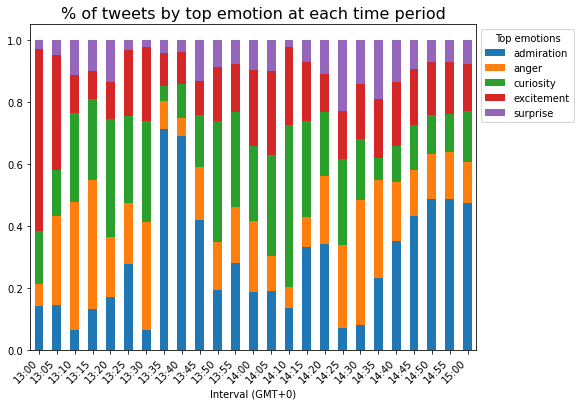

In [73]:
plot_df.pivot_table(index=['interval'], 
                    columns='grp_label', 
                    values='tweet_clean').apply(lambda x: x / sum(x), axis = 1)\
                    .plot(kind='bar', stacked=True, figsize = (8,6))
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Interval (GMT+0)')
plt.legend(title = 'Top emotions', bbox_to_anchor=(1, 1), fontsize='medium', fancybox=True)
plt.title('% of tweets by top emotion at each time period', fontsize=16);